### **Librairies**

In [6]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import skimage.io as io
import math
from PIL import Image
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.exposure import histogram, cumulative_distribution
from skimage import img_as_ubyte, img_as_float
from scipy.stats import norm
from copy import deepcopy
import os
from os import listdir
import time


### **Exemple d'image**

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (128, 128, 3)
Hight of the image 128
Width of the image 128
Dimension of the Image 3


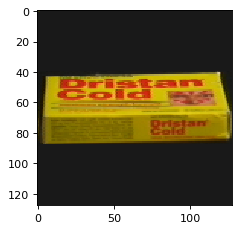

In [ ]:
img = imread('archive/coil-100/coil-100/obj1__0.png')
plt.figure(num=None, figsize=(4, 3), dpi=80)
imshow(img)
#basic properties of image
print('Type of the image : ',type(img))
print('Shape of the image : {}'.format(img.shape))
print('Hight of the image {}'.format(img.shape[0]))
print('Width of the image {}'.format(img.shape[1]))
print('Dimension of the Image {}'.format(img.ndim)) 


We can see the shape of the image is three-layered and its width is 128, and the height of the image is 128. The type of image is an np array three-layered matrix.

### **Transformation de RGB à "Encoding Opponent"**

In [ ]:
import cv2
import numpy as np

def read_image(file_image):
    #change BGR to RGB
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#open image
    img_array = image #array des valeurs r,g,b de chaque pixels 
    return img_array




In [9]:
#opponent encoding
#rg = r - g
#by = 2*b -r - g
#wb = r + g + b
def opponent_encoding(img_array):
    np.seterr(over='ignore')
    new_shape = [[[0 for k in range(3)] for j in range(img_array.shape[1])] for i in range(img_array.shape[0])]
    for i in range(len(img_array)):
        for j in range(len(img_array[i])):
            new_shape[i][j][0] = int(img_array[i][j][0] - img_array[i][j][1])
            new_shape[i][j][1] = int((2*img_array[j][i][2]) -img_array[i][j][0] - img_array[i][i][1])
            new_shape[i][j][2] = int(img_array[i][j][0] + img_array[i][j][1] + img_array[i][i][2])
    new_shape = np.array(new_shape)
    return new_shape

In [10]:
#normalization rg,by,wb
def normalization_array(new_shape):
    normalized = [[[0 for k in range(3)] for j in range(new_shape.shape[1])] for i in range(new_shape.shape[0])]
    for i in range(len(new_shape)):
        for j in range(len(new_shape[i])):
            normalized[i][j][0] = int(math.floor(((new_shape[i][j][0] + 255) / 510)*8))
            normalized[i][j][1] = int(math.floor(((new_shape[i][j][1] + 255) / 510)*16))
            normalized[i][j][2] = int(math.floor(((new_shape[i][j][2] + 255) / 510)*16))
    normalized = np.array(normalized)
    return normalized

In [ ]:
def features_vector(normalized):
    normalized = normalized.astype(np.float32)
    hist = cv2.calcHist([normalized], #image pixel values array
                        [0, 1, 2], #which channels do you (all RGB channels here)
                        None, #mask, not used in this
                        [8, 16, 16], # how many descriptors do you want per channel?
                        [0, 8, 0, 16, 0, 16] # what is the range of values per color channel?
                       )
    features = cv2.normalize(hist, hist).flatten()
    return features

In [ ]:
def clustering(image_path):
    
    img_array = read_image(image_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    new_shape = opponent_encoding(img_array)
    normalized = normalization_array(new_shape)

    pixel_values = img_array.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    print(pixel_values.shape)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # number of clusters (K)
    k = 25
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(img_array.shape)
    # show the image
    plt.imshow(segmented_image)
    plt.show()

### **Image après la transformation**

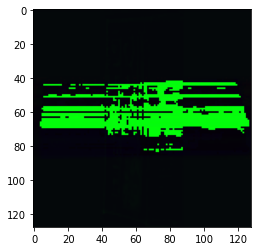

In [39]:
from matplotlib import pyplot as plt
img_array = read_image("archive/coil-100/coil-100/obj1__0.png")
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
new_shape = opponent_encoding(img_array)
normalized = normalization_array(new_shape)
normalized = normalized.astype(np.uint8)
plt.imshow(normalized)
plt.show()

### **Mesures de similarité entre images (distance niveau de gris)**

In [ ]:
def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return np.average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

In [ ]:
index_version1 = {}
images_version1 = {}

In [ ]:
start_time = time.time()
folder_dir = "archive/coil-100/coil-100/"
j=1
for i in range(1,101):
    for j in range(0,356,5):
        imagename = folder_dir + "obj" + str(i) + "__" + str(j) + ".png"
        image = cv2.imread(imagename)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        index_img = "i" + str(i) + "__" + str(j)
        images_version1[index_img] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        hist =  cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        index_version1[index_img] = hist
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.6709249019622803 seconds ---


In [ ]:
print(len(images_version1))

7200


In [ ]:
def grayscale_distance(histA, histB,):
    d = np.sum([abs(a - b) for (a, b) in zip(histA, histB)])
    return d/256 #16777216 = nombre de cases

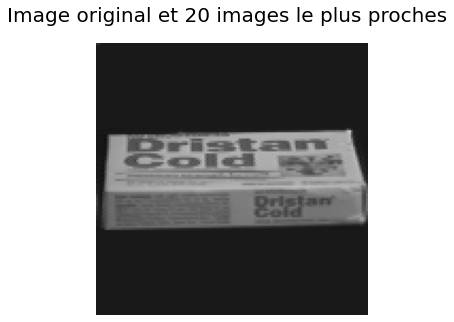

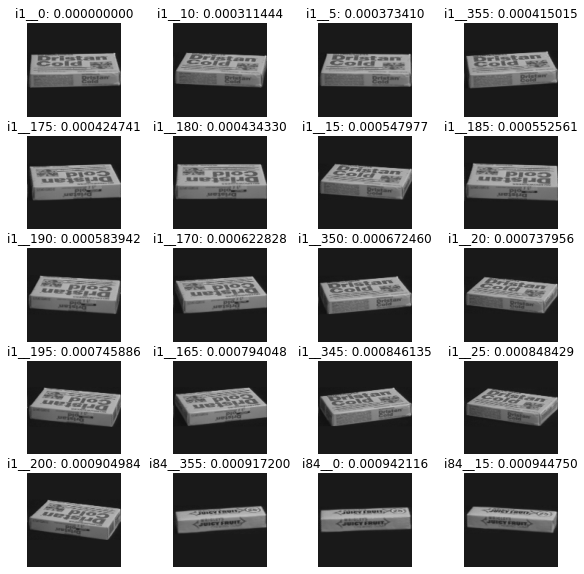

--- 0.8946506977081299 seconds ---


In [ ]:
start_time = time.time()
results_version1 = {}
# results_version1loop over the index
for (k, hist) in index_version1.items():
    d = grayscale_distance(index_version1["i1__0"], hist)
    results_version1[k] = d

results_version1 = sorted([(v, k) for (k, v) in results_version1.items()])

fig=plt.figure(figsize=(5,5))
fig.suptitle("Image original et 20 images le plus proches",fontsize = 20)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(cv2.cvtColor(images_version1["i1__0"],cv2.COLOR_GRAY2RGB))
plt.axis("off")

fig2=plt.figure(figsize=(10,10))

new = results_version1[0:20]
for (i, (v, k)) in enumerate(new):
    ax = fig2.add_subplot(5, 4, i + 1)
    ax.set_title("%s: %.9f" % (k, v))
    plt.imshow(cv2.cvtColor(images_version1[k],cv2.COLOR_GRAY2RGB))
    plt.axis("off")

plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

### **Mesures de similarité entre images (avec la nouvelle représentation)**

In [ ]:
index = {}
images = {}

In [35]:
start_time = time.time()
folder_dir = "archive/coil-100/coil-100/"
j=1
for i in range(1,101):
    for j in range(0,356,5):
        imagename = folder_dir + "obj" + str(i) + "__" + str(j) + ".png"
        image = cv2.imread(imagename)
        index_img = "i" + str(i) + "__" + str(j)
        images[index_img] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        new_shape = opponent_encoding(image)
        normalized = normalization_array(new_shape)


        normalized = normalized.astype(np.uint8)
        hist = cv2.calcHist([normalized], [0, 1, 2], None, [8, 16,16],
            [0, 8, 0, 16, 0, 16])

        hist = cv2.normalize(hist, hist).flatten()

        index[index_img] = hist

print("--- %s seconds ---" % (time.time() - start_time))
            

--- 1143.5494403839111 seconds ---


In [36]:
print(len(images))
        

7200


In [37]:
def image_distance(histA, histB,):
    d = np.sum([abs(a - b) for (a, b) in zip(histA, histB)])
    return d/2048 #2048 = nombre de cases

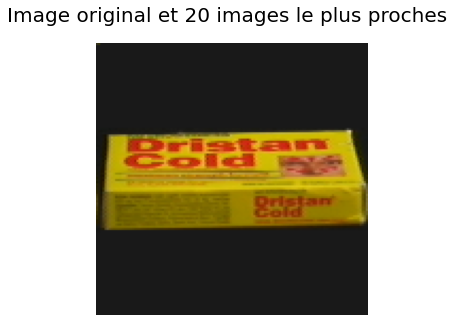

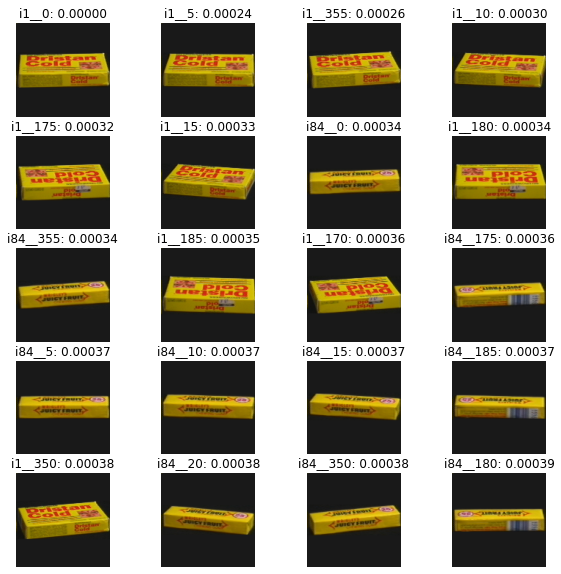

--- 3.1523027420043945 seconds ---


In [38]:
start_time = time.time()
results = {}
# loop over the index
for (k, hist) in index.items():
    d = image_distance(index["i1__0"], hist)
    results[k] = d

results = sorted([(v, k) for (k, v) in results.items()])

fig=plt.figure(figsize=(5,5))
fig.suptitle("Image original et 20 images le plus proches",fontsize = 20)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(images["i1__0"])
plt.axis("off")

fig2=plt.figure(figsize=(10,10))

new = results[0:20]
for (i, (v, k)) in enumerate(new):
    ax = fig2.add_subplot(5, 4, i + 1)
    ax.set_title("%s: %.5f" % (k, v))
    plt.imshow(images[k])
    plt.axis("off")

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

### **Segmentation image avec RGB coordonnées**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [11]:
img_array = cv2.imread("archive/coil-100/coil-100/obj55__0.png")
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
im = img_array
new_shape = opponent_encoding(img_array)
normalized = normalization_array(new_shape)
normalized = normalized.astype(np.uint8)
original_shape = im.shape
print(im.shape)

(128, 128, 3)


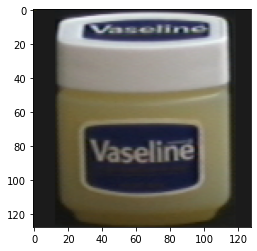

In [12]:
plt.imshow(im) # as RGB Format
plt.show()


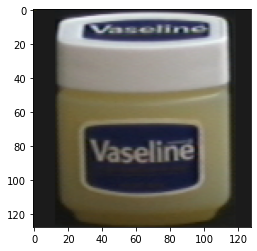

In [13]:
plt.imshow(im) # as RGB Format
plt.show()

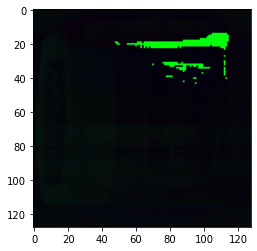

In [14]:
plt.imshow(normalized) # as RGB Format
plt.show()

In [15]:
# Flatten Each channel of the Image
all_pixels  = im.reshape((-1,3))
print(all_pixels.shape)

(16384, 3)


In [16]:
# Flatten Each channel of the Image
all_pixels2  = normalized.reshape((-1,3))
print(all_pixels.shape)

(16384, 3)


In [19]:
from sklearn.cluster import KMeans

In [20]:
dominant_colors = 4

km = KMeans(n_clusters=dominant_colors)
km.fit(all_pixels)

KMeans(n_clusters=4)

In [21]:
dominant_colors2 = 4

km2 = KMeans(n_clusters=dominant_colors2)
km2.fit(all_pixels2)

KMeans(n_clusters=4)

In [22]:
centers = km.cluster_centers_
print(centers) # In RGB Format

[[142.50663329 136.63329161 117.42403004]
 [ 31.2738982   31.29562384  35.57278088]
 [ 95.42315902  87.4434365   64.01814301]
 [190.69731452 191.57669549 191.74965863]]


In [23]:
centers2 = km2.cluster_centers_
print(centers2) # In RGB Format

[[  4.54292343   7.26282547  11.22931168]
 [  6.16045845 254.50716332  11.14040115]
 [  4.57935484  13.70290323  11.39096774]
 [  4.69847402   2.63453738  12.56635117]]


In [24]:
# Convert to Integer format
centers = np.array(centers,dtype='uint8')

In [25]:
# Convert to Integer format
centers2 = np.array(centers2,dtype='uint8')

In [26]:
print(centers)

[[142 136 117]
 [ 31  31  35]
 [ 95  87  64]
 [190 191 191]]


In [27]:
print(centers2)

[[  4   7  11]
 [  6 254  11]
 [  4  13  11]
 [  4   2  12]]


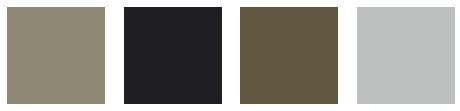

In [28]:
i = 1

plt.figure(0,figsize=(8,2))

# Storing info in color array
colors = []

for each_col in centers:
    plt.subplot(1,4,i)
    plt.axis("off")
    i+=1
    
    colors.append(each_col)
    
    # Color Swatch
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = each_col
    plt.imshow(a)
    
plt.show()

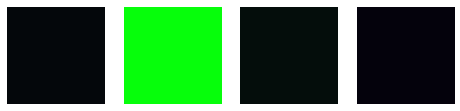

In [29]:
i = 1

plt.figure(0,figsize=(8,2))

# Storing info in color array
colors2 = []

for each_col in centers2:
    plt.subplot(1,4,i)
    plt.axis("off")
    i+=1
    
    colors2.append(each_col)
    
    # Color Swatch
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = each_col
    plt.imshow(a)
    
plt.show()

In [30]:
new_img = np.zeros((128*128,3),dtype='uint8')
print(new_img.shape)

(16384, 3)


In [31]:
new_img2 = np.zeros((128*128,3),dtype='uint8')
print(new_img2.shape)

(16384, 3)


In [32]:
colors

[array([142, 136, 117], dtype=uint8),
 array([31, 31, 35], dtype=uint8),
 array([95, 87, 64], dtype=uint8),
 array([190, 191, 191], dtype=uint8)]

In [33]:
colors2

[array([ 4,  7, 11], dtype=uint8),
 array([  6, 254,  11], dtype=uint8),
 array([ 4, 13, 11], dtype=uint8),
 array([ 4,  2, 12], dtype=uint8)]

In [34]:
km.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [35]:
km2.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

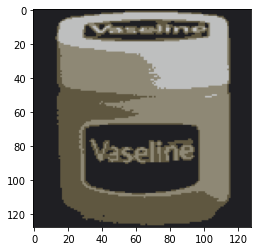

In [36]:
# Iterate over the image
for ix in range(new_img.shape[0]):
    new_img[ix] = colors[km.labels_[ix]]
    
new_img = new_img.reshape((original_shape))
plt.imshow(new_img)
plt.show()

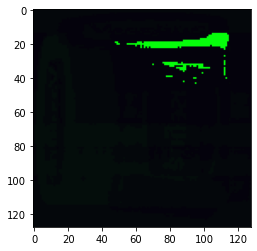

In [39]:

for ix in range(new_img2.shape[0]):
    new_img2[ix] = colors2[km2.labels_[ix]]
    
new_img2 = new_img2.reshape((original_shape))
plt.imshow(new_img2)
plt.show()

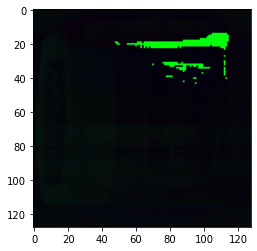

In [40]:
plt.imshow(normalized) # as RGB Format
plt.show()